# Modelo de Expected Assists (xA) con StatsBomb Open Data
Este cuaderno calcula las Expected Assists (xA) identificando los pases que terminan en disparo y asignándoles el valor xG del disparo correspondiente.

In [ ]:
# 🔧 Instalación de librerías necesarias
# Ejecuta esto solo si aún no las tienes
# !pip install pandas numpy matplotlib seaborn scikit-learn statsbombpy

In [1]:
# 📥 Cargar datos de StatsBomb
from statsbombpy import sb
import pandas as pd
import numpy as np

# Cargar eventos del Mundial Femenino 2019
matches = sb.matches(competition_id=72, season_id=30)
match_id = matches.iloc[0]['match_id']
events = sb.events(match_id=match_id)

# Filtrar eventos de pases y disparos
passes = events[events['type'] == 'Pass'].copy()
shots = events[events['type'] == 'Shot'].copy()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [2]:
# 📐 Ingeniería de variables para disparos
from math import atan2, degrees

def get_shot_features(df):
    goal_x, goal_y = 120, 40
    df['x'] = df['location'].apply(lambda loc: loc[0])
    df['y'] = df['location'].apply(lambda loc: loc[1])
    df['distance'] = np.sqrt((goal_x - df['x'])**2 + (goal_y - df['y'])**2)
    df['angle'] = df.apply(lambda row: abs(degrees(atan2(7.32 / 2, row['distance'])) * 2), axis=1)
    df['is_goal'] = df['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)
    return df

shots = get_shot_features(shots)

In [3]:
# 🤖 Entrenamiento del modelo xG
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = shots[['distance', 'angle']]
y = shots['is_goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xg_model = LogisticRegression()
xg_model.fit(X_train, y_train)

# Añadir predicción xG al dataframe de disparos
shots['xG'] = xg_model.predict_proba(shots[['distance', 'angle']])[:, 1]

In [4]:
# 🔗 Asociar cada disparo a su pase asistente
# Solo usamos pases que resultan en disparos (pases clave)
key_passes = passes[passes['pass_assisted_shot_id'].notnull()].copy()
key_passes['shot_id'] = key_passes['pass_assisted_shot_id']

# Unir los pases clave con sus disparos correspondientes
key_passes = key_passes.merge(shots[['id', 'xG']], how='left', left_on='shot_id', right_on='id')
key_passes.rename(columns={'xG': 'xA'}, inplace=True)

# Visualizar xA por jugador
xA_per_player = key_passes.groupby('player')['xA'].sum().sort_values(ascending=False)
xA_per_player.head(10)


player
Lucía García Córdoba                6.906646e-03
Svenja Huth                         6.157045e-05
Jennifer Hermoso Fuentes            2.017308e-05
Lena Goeßling                       1.115422e-05
Sara Däbritz                        4.983977e-06
Silvia Meseguer Bellido             3.045762e-06
María Francesca Caldentey Oliver    2.039117e-07
Klara Bühl                          2.035969e-07
Alexandra Popp                      1.302592e-07
Irene Paredes Hernandez             1.109686e-07
Name: xA, dtype: float64

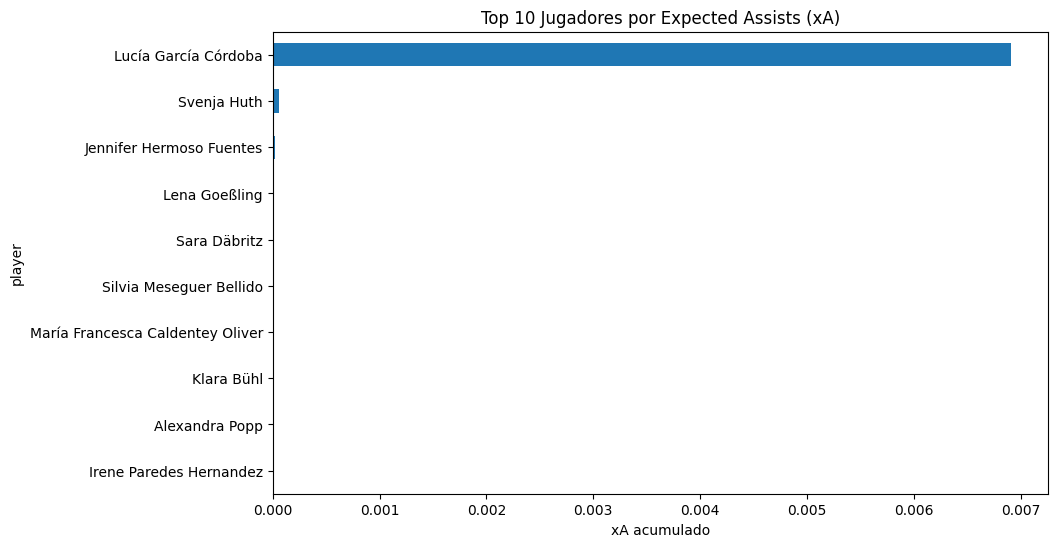

In [5]:
# 📊 Visualización de los jugadores más creativos
import matplotlib.pyplot as plt

xA_per_player.head(10).plot(kind='barh', figsize=(10,6), title='Top 10 Jugadores por Expected Assists (xA)')
plt.xlabel('xA acumulado')
plt.gca().invert_yaxis()
plt.show()